# Final Project

In [2]:
import serial, time

## Data Collection
Run below cells to collect twitch data

In [3]:
resolution = 100
duration = 10

# Setup Serial Communication
ser = serial.Serial('COM4') # TODO: Check if correct COM/TTYL port
ser.baudrate = 9600
start_time = time.time()

# Start Data Logging
f = open('{0}.txt'.format(start_time), "w")
while True:
    curr_time = time.time()
    if (curr_time - start_time > duration):
        break
    ser.write(str.encode('l'))
    f.write(str(ser.readline()))
ser.close()
f.close()


## Model Fitting
https://www.tensorflow.org/lite/microcontrollers 

https://github.com/tensorflow/decision-forests

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils

#### Load and Preprocess Data

In [14]:
# Match motion data averaged to the second to sleep data timestamps
def get_matched_time_data_average(motion, sleep):
    # Average out motion data
    motion_time = np.clip(np.floor(motion['time']), min(sleep['time']), max(sleep['time']))
    motion_time, motion_indices = np.unique(motion_time, return_index=True)
    avg_x = np.array([np.average(motion['x'][i]) for i in motion_indices])
    avg_y = np.array([np.average(motion['y'][i]) for i in motion_indices])
    avg_z = np.array([np.average(motion['z'][i]) for i in motion_indices])

    # Match up motion data with sleep data
    _, _, indices = np.intersect1d(sleep['time'], motion_time, return_indices=True)
    data = np.array([sleep['time'], avg_x[indices], avg_y[indices], avg_z[indices], sleep['label']]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

# Assign motion data averaged to the second to sleep labels
def get_assigned_time_data_average(motion, sleep):
    # Average out motion data
    motion_time = np.clip(np.floor(motion['time']), min(sleep['time']), max(sleep['time']))
    motion_time, motion_indices = np.unique(motion_time, return_index=True)
    avg_x = np.array([np.average(motion['x'][i]) for i in motion_indices])
    avg_y = np.array([np.average(motion['y'][i]) for i in motion_indices])
    avg_z = np.array([np.average(motion['z'][i]) for i in motion_indices])

    # Assign sleep label to motion data
    labels = []
    index = 0
    for t in range(len(motion_time)):
        if (t > sleep['time'][index]):
            index += 1
        labels.append(sleep['label'][index])
    data = np.array([motion_time, avg_x, avg_y, avg_z, labels]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def load_data(file_num, path=''):
    motion_file = f'{path}/motion/{file_num}_acceleration.txt'
    sleep_file  = f'{path}/labels/{file_num}_labeled_sleep.txt'
    motion_data = pd.read_csv(motion_file, delimiter=' ', names=['time', 'x', 'y', 'z'])
    sleep_data  = pd.read_csv(sleep_file, delimiter=' ', names=['time', 'label'])
    return motion_data, sleep_data

def plot_data(df):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
    colors = ['r', 'm', 'y', 'g', 'b', 'c']
    [plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]
    

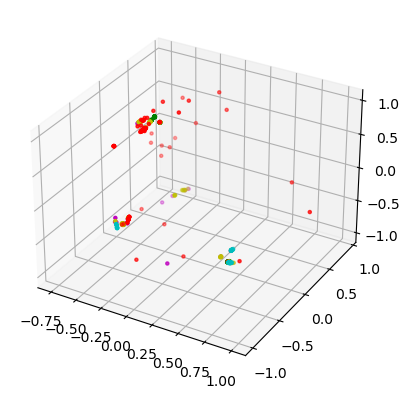

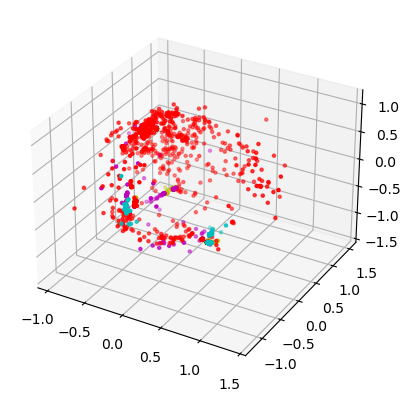

In [15]:
file_nums = ['46343', '759667', '781756']
motion, sleep = load_data(file_nums[0], './data')

matched_time_data_average_df = get_matched_time_data_average(motion, sleep)
assigned_time_data_average_df = get_assigned_time_data_average(motion, sleep)

plot_data(matched_time_data_average_df)
plot_data(assigned_time_data_average_df)

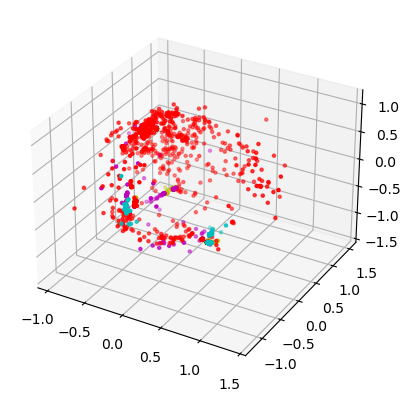

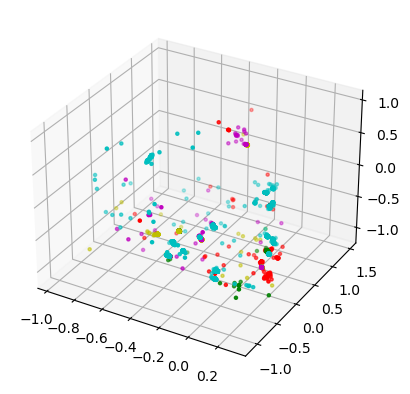

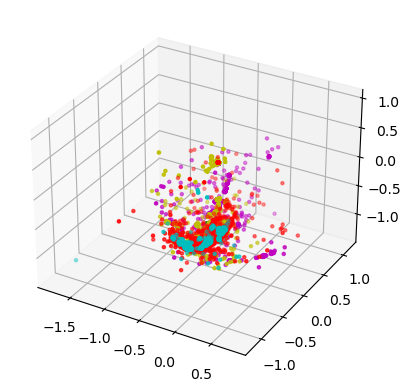

In [16]:
data = [load_data(file_nums[i], './data') for i in range(3)]
prep_func = lambda d: get_assigned_time_data_average(d[0], d[1])
train_data, valid_data, test_data = [sklearn.utils.shuffle(prep_func(d)) for d in data]
[plot_data(d) for d in (train_data, valid_data, test_data)]
x_train, x_valid, x_test = [np.array([d['x'], d['y'], d['z']]).T for d in (train_data, valid_data, test_data)]
y_train, y_valid, y_test  = [d['label'] for d in (train_data, valid_data, test_data)]

#### Train Model

In [17]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [18]:
import tensorflow as tf
from tensorflow import keras

In [19]:
seed = 1
# np.random.seed(seed)
tf.random.set_seed(seed)

In [41]:
# Simple Neural Network
model_1 = tf.keras.Sequential()
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(3,)))
model_1.add(keras.layers.Dense(1))
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [38]:
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_valid, y_valid))
model_1.save()

Epoch 1/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8275 - mae: 0.6513 - val_loss: 9.9542 - val_mae: 2.6187
Epoch 2/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8281 - mae: 0.6512 - val_loss: 10.4084 - val_mae: 2.6921
Epoch 3/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8266 - mae: 0.6515 - val_loss: 10.4951 - val_mae: 2.7041
Epoch 4/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8278 - mae: 0.6503 - val_loss: 10.0137 - val_mae: 2.6282
Epoch 5/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8284 - mae: 0.6525 - val_loss: 9.8623 - val_mae: 2.6016
Epoch 6/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8280 - mae: 0.6511 - val_loss: 10.7000 - val_mae: 2.7379
Epoch 7/500
260/260 [==============================] - 1s 3ms/step - loss: 0.8280 - mae: 0.6523 - val_loss: 10.5212 - val_mae: 2.7144
Epoch 8/500
260/260 [==============================] - 1s 3ms/st

TypeError: Model.save() missing 1 required positional argument: 'filepath'

In [40]:
model_1.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1/assets


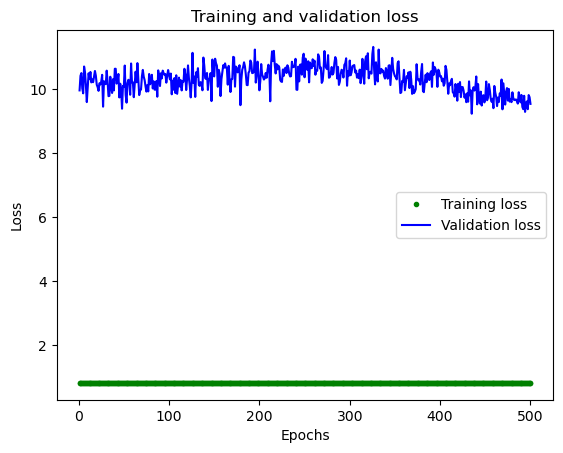

In [43]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

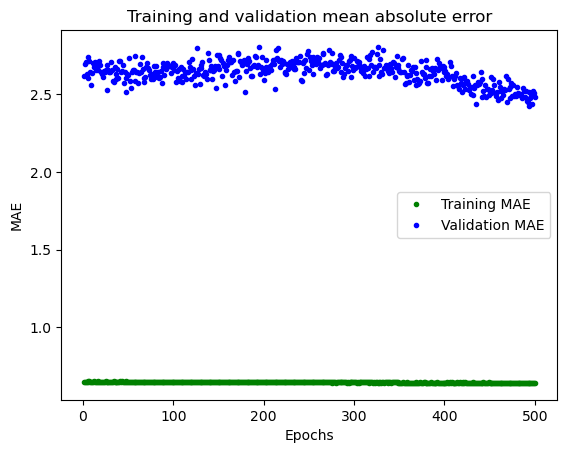

In [44]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs, train_mae, 'g.', label='Training MAE')
plt.plot(epochs, val_mae, 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

916/916 [==============================] - 1s 971us/step


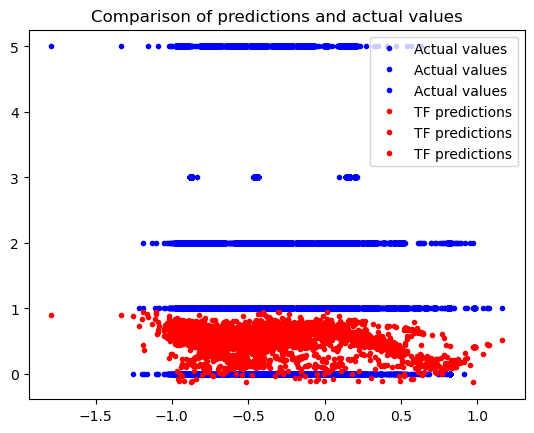

In [45]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

In [47]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

OSError: SavedModel file does not exist at: models/model/{saved_model.pbtxt|saved_model.pb}

In [34]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

NameError: name 'model' is not defined

In [ ]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

In [ ]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [ ]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [ ]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

In [27]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [28]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
};
unsigned int g_model_len = 0;
